# MIDRC Open-R1 Clinical Data

*Please note: This notebook uses open access data*

##### Created By: J Montgomery Maxwell

In this notebook we will visualize the distribution of subjects accross a variety demographics and their COVID-19 status in the Open-R1 dataset from The Medical Imaging and Data Resource Center. (MIDRC - https://data.midrc.org/)

The Open-R1 data set has 1,169 subjects, this notebook will compare the distribution of COVID-19 positive and negative patients across multiple demographic classes. In particular we will focus on the subjects' age groups (-20, 21-30, ..., 90+), sex (Male or Female), race (Black or African American, White, Asian, Pacific Islander, American Indian, Other, or Not Reported), and whether the subject is Hispanic or Latino. Below is a subset of the dataset.

In [1]:
# The packages below may be necessary for users to install according to the imports necessary in the subsequent cells.

#!pip install --upgrade pandas
#!pip install --upgrade --ignore-installed PyYAML
#!pip install --upgrade pip
#!pip install --upgrade gen3 --user --upgrade
#!pip install cdiserrors
#!pip install --upgrade pydicom

In [2]:
import pandas as pd
import sys, os, webbrowser
import gen3
import pydicom
import matplotlib.pyplot as plt

from gen3.submission import Gen3Submission
from gen3.auth import Gen3Auth
from gen3.index import Gen3Index
from gen3.query import Gen3Query

In [3]:
# Import some custom Python scripts from personal GitHub repo.
# Change these directory paths to reflect your local working directory.

home_dir = "/Users/christopher" 
demo_dir = "{}/Documents/Notes/MIDRC/tutorials".format(home_dir)

os.chdir(demo_dir)

os.system("wget https://raw.githubusercontent.com/cgmeyer/gen3sdk-python/master/expansion/expansion.py -O {}/expansion.py".format(demo_dir))
%run expansion.py


In [4]:
# Initiate instances of the Gen3 SDK Classes using credentials file for authentication.
# Change the directory path in "cred" to reflect the location of your credentials file.

api = "https://data.midrc.org"
cred = "{}/Downloads/midrc-credentials.json".format(home_dir)
auth = Gen3Auth(api, refresh_file=cred) # authentication class
sub = Gen3Submission(api, auth) # submission class
query = Gen3Query(auth) # query class
exp = Gen3Expansion(api,auth,sub) # class with some custom scripts
exp.get_project_ids()


Getting all project_ids you have access to in the data commons.
['Open-A1', 'Open-A1_PETAL_REDCORAL', 'Open-R1', 'TCIA-RICORD']


/Users/christopher/Documents/Notes/MIDRC/tutorials/expansion.py:213: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = json_normalize(res["data"]["project"])


['Open-A1', 'Open-A1_PETAL_REDCORAL', 'Open-R1', 'TCIA-RICORD']

In [5]:
#Function to sort subjects into various age groups
def age_group(agelist):
    min_age = min(agelist)
    groups = ["-20 yr", "21-30 yr", "31-40 yr", "41-50 yr", "51-60 yr", "61-70 yr", "71-80 yr", "81-90 yr", "90+ yr"]
    grouplist = []
    for i in agelist:
        if i <= 20:
            grouplist.append(groups[0])
        elif i <= 30:
            grouplist.append(groups[1])
        elif i <= 40:
            grouplist.append(groups[2])
        elif i <= 50:
            grouplist.append(groups[3])
        elif i <= 60:
            grouplist.append(groups[4])
        elif i <= 70:
            grouplist.append(groups[5])
        elif i <= 80:
            grouplist.append(groups[6])
        elif i <= 90:
            grouplist.append(groups[7])
        else:
            grouplist.append(groups[8])
            
    return grouplist

#Function to represent various demographics into a precent positivity statistic
def percent_representation(df, demographic_type, demographics):

    positive_df = df[df['covid19_positive'] == 'Yes']
    negative_df = df[df['covid19_positive'] == 'No']
    
    neg_percents = []
    pos_percents = []
    for demo in demographics:
        neg_percents.append(round(len(negative_df[negative_df[demographic_type] == demo])/len(negative_df), 4)*100)
        pos_percents.append(round(len(positive_df[positive_df[demographic_type] == demo])/len(positive_df), 4)*100)
        
    neg = pd.DataFrame()
    pos = pd.DataFrame()     
    
    neg[demographic_type] = demographics
    neg['Percent'] = neg_percents
    neg['COVID-19 Status'] = 'Negative'
    
    pos[demographic_type] = demographics
    pos['Percent'] = pos_percents
    pos['COVID-19 Status'] = 'Positive'
        
    return pd.concat([neg, pos])

In [6]:
#Using the Gen3 connection "sub" data for project R1 is downloaded and converted into a data frame
cases = sub.export_node(program='Open',project='R1',node_type='case',fileformat='tsv')
df = pd.read_csv(StringIO(cases), sep='\t', header=0)
df['zip'] = df['zip'].astype(str)
df['age_group'] = age_group(df['age_at_index'])

df.loc[df.race == 'Native Hawaiian or other Pacific Islander', 'race'] = 'Pacific Islander'
df.loc[df.race == 'American Indian or Alaskan Native', 'race'] = 'American Indian' 
df.loc[df.race == 'Black or African American', 'race'] = 'Black or A.A.' 
df = df[['covid19_positive', 'age_group', 'sex', 'ethnicity', 'race']]
df.head()


,covid19_positive,age_group,sex,ethnicity,race
0,No,71-80 yr,Male,Not Hispanic or Latino,White
1,No,61-70 yr,Male,Not Hispanic or Latino,Not Reported
2,No,71-80 yr,Male,Not Hispanic or Latino,White
3,No,51-60 yr,Male,Not Hispanic or Latino,Black or A.A.
4,No,71-80 yr,Female,Not Hispanic or Latino,Not Reported


### Subjects' COVID-19 Status

Approximately 22% of the subjects in the Open-R1 dataset were COVID-19 positive at the time of the dataset indexing. 

In [7]:
covid_breakdown = {'Number of COVID-19 positive subjects': len(df[df['covid19_positive'] == 'Yes']['covid19_positive']), 
                   'Number of COVID-19 negative subjects': len(df[df['covid19_positive'] == 'No']['covid19_positive']), }
print(covid_breakdown)

print("Positivity percentage = {}%".format(round(list(covid_breakdown.items())[0][1]/list(covid_breakdown.items())[1][1]*100,1)))

{'Number of COVID-19 positive subjects': 1385, 'Number of COVID-19 negative subjects': 6331}
Positivity percentage = 21.9%


## Subject Distribution

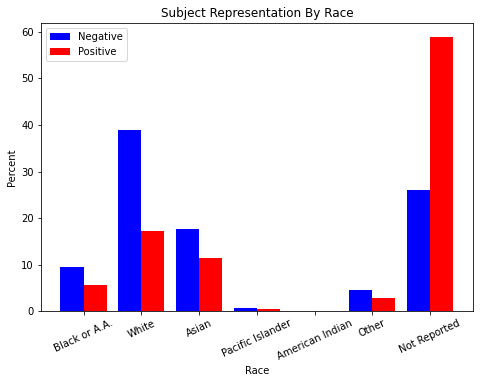

In [8]:
races = ['Black or A.A.', 
         'White', 
         'Asian', 
         'Pacific Islander', 
         'American Indian', 
         'Other', 
         'Not Reported']
plot_df = percent_representation(df, 'race', races)
X = np.arange(len(races))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X - 0.2, plot_df[plot_df['COVID-19 Status'] == 'Negative']['Percent'], color='b', width=0.4, label='Negative')
ax.bar(X + 0.2, plot_df[plot_df['COVID-19 Status'] == 'Positive']['Percent'], color='r', width=0.4, label='Positive')

ax.set_xticks(X)
ax.set_xticklabels(races, rotation=25)
ax.set_ylabel('Percent')
ax.set_xlabel('Race')
ax.set_title('Subject Representation By Race')

ax.legend()
plt.show()  

Users can examine the ratio of Negative and Positive COVID cases amoungst various demographics.  At many points thoughout the first two years of the pandemic, desparities of COVID positivity ratios were often noted.  Additionally, since subjects possess the ability to not report their race (Not Reported), differences in positivity ratios can be observed if present.

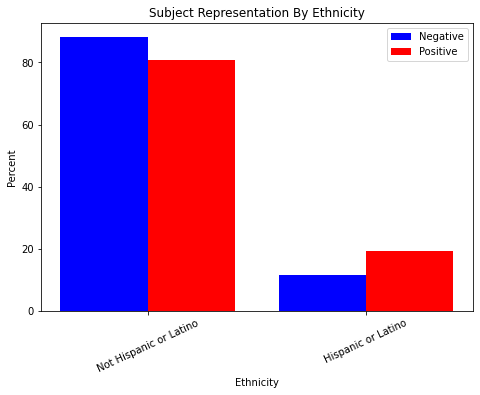

In [9]:
ethnicities = ['Not Hispanic or Latino', 'Hispanic or Latino'] 

plot_df = percent_representation(df, 'ethnicity', ethnicities)
X = np.arange(len(ethnicities))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X - 0.2, plot_df[plot_df['COVID-19 Status'] == 'Negative']['Percent'], color='b', width=0.4, label='Negative')
ax.bar(X + 0.2, plot_df[plot_df['COVID-19 Status'] == 'Positive']['Percent'], color='r', width=0.4, label='Positive')

ax.set_xticks(X)
ax.set_xticklabels(ethnicities, rotation=25)
ax.set_ylabel('Percent')
ax.set_xlabel('Ethnicity')
ax.set_title('Subject Representation By Ethnicity')

ax.legend()
plt.show()  

When reduced to only two groups (Not Hispanic or Latino verse Hispanic or Latino), differences in COVID positivity can be observed if present.

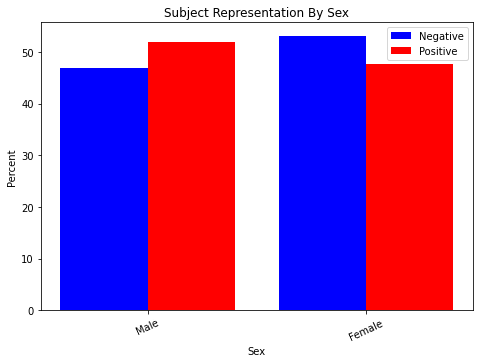

In [10]:
sexes = ['Male', 'Female'] 

plot_df = percent_representation(df, 'sex', sexes)
X = np.arange(len(sexes))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X - 0.2, plot_df[plot_df['COVID-19 Status'] == 'Negative']['Percent'], color='b', width=0.4, label='Negative')
ax.bar(X + 0.2, plot_df[plot_df['COVID-19 Status'] == 'Positive']['Percent'], color='r', width=0.4, label='Positive')

ax.set_xticks(X)
ax.set_xticklabels(sexes, rotation=25)
ax.set_ylabel('Percent')
ax.set_xlabel('Sex')
ax.set_title('Subject Representation By Sex')

ax.legend()
plt.show()  

If present, a disparity of COVID positivity can be noted between sexes.

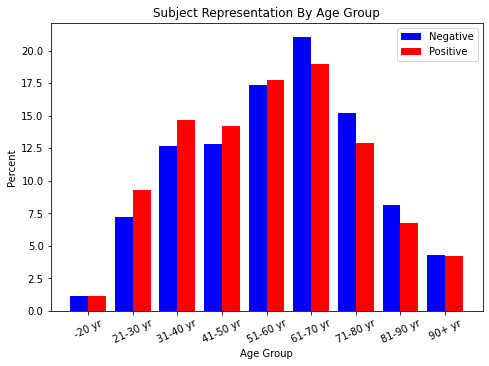

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ages = ["-20 yr", "21-30 yr", "31-40 yr", "41-50 yr", "51-60 yr", "61-70 yr", "71-80 yr", "81-90 yr", "90+ yr"]

plot_df = percent_representation(df, 'age_group', ages)
X=np.arange(9)

ax.bar(X - 0.2, 
       plot_df[plot_df['COVID-19 Status'] == 'Negative']['Percent'], color='b', width=0.4, label='Negative')

ax.bar(X + 0.2, 
       plot_df[plot_df['COVID-19 Status'] == 'Positive']['Percent'], color='r', width=0.4, label='Positive')
ax.set_xticks(X)
ax.set_xticklabels(ages, rotation=25)

ax.set_ylabel('Percent')
ax.set_xlabel('Age Group')

ax.set_title('Subject Representation By Age Group')

ax.legend()
plt.show()        

The affect age plays in the prevalence of COVID positivity is displayed above.  It should be noted that this chart is not normalized by the age distribution of the general population.  Typically though, individuals <20 years represent a significant portion of most general populations.